# E2a: Küchentischversuch zum Laval-Rotor

Name: Noel Schwibus 

Datum: 02.01.2024

## Forschungsfrage

Formulieren Sie eine oder mehrere Forschungsfragen zu der Lerneinheit:

Wie gut kann die Beschleunigung der Haushaltsgeräte ermittelt werden? Können Charakteristiken der Haushaltsgeräte erkannt werden?

# Erster Versuch
Hier werden Sie den ersten Gegenstand auswerten. Die Auswertung des zweiten Gegenstands kann das analog erfolgen, die entsprechenden jupyter-notebook-Zellen sind weiter unten vorbereitet.

##  Versuchsaufbau und -durchführung

Beachten Sie, dass Sie den Code zum Auslesen des Beschleunigungssensor ausschließlich mit dem Raspberry Pi ausführen können.

- Bild von Aufbau des Haushaltsgegenstands:

<img src="figures/mixer.jpg" width="500">

- Beschreibung des Aufbaus:

Der Mixer steht ohne montierte Rührgeräte auf einem Tisch. An dem Mixer ist ein Beschleunigungssensor mit Klebeband festgeklebt. Der Beschleunigungssensor ist über Jumperkabel mit dem Raspberry Pi verbunden. 
- Vorgangsbeschreibung:

Der Mixer wird angeschaltet und dreht bei konstanter Drehzahl. Anschließend wird das Messprogramm gestartet und somit die Beschleunigung gemessen. Nach 20 Sekunden endet die Messdauer und der Mixer wird abgeschaltet.

## Versuchsauswertung

Die Vermessung des Haushaltsgegenstands wird in diesem Notebook ausgewertet, dazu werden die drei Funktionen ```get_vec_accel()```, ```interpolation()``` und ```my_fft()``` in ```functions/m_postprocessing.py``` verwendet. Die Ein- und Ausgangsgrößen der Funktionen sind in ```functions/m_postprocessing.py``` definiert, bitte berücksichtigen Sie die vordefinierten Datentypen.


Alle Codeblöcke, in denen Sie Änderungen vornehmen müssen, sind nachfolgend markiert.

In [35]:
import h5py
import numpy as np
import json
import os

from typing import Tuple

%matplotlib inline
import matplotlib.pyplot as plt

from functions.m_operate import evaluate_metadata

from functions.m_postprocessing import get_vec_accel
from functions.m_postprocessing import interpolation
from functions.m_postprocessing import my_fft

path = os.path.join("supplementary_code", "FST.mplstyle")
plt.style.use(path)

#### 1a. Einlesen der Mess- und Metadaten

In [36]:
"""Parameter definition"""
# -------------------------------------------------------------------------------------------#1-start
# TODO: Adjust the parameters to your needs. Please use relative paths!
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
path_measurement_folder = "measurement_data/data_20240102_192700_NoelSchwibus_mixer" # replace None by the relative path to the first object's folder
h5_file_name = "data_20240102_192700_NoelSchwibus_mixer.h5" # replace None by the filename of the hdf5-file
# ---------------------------------------------------------------------------------------------#1-end

In [37]:
"""Prepare Metadata"""
(setup_json_dict, sensor_settings_dict, probe_name) = evaluate_metadata(
    path_measurement_folder
)

print(json.dumps(setup_json_dict, indent=2, default=str))
print(json.dumps(sensor_settings_dict, indent=2, default=str))
print("Probe: {}".format(probe_name))


{
  "1ee846ef-4df0-632a-bfdb-ef2ea3181b39": {
    "type": "general",
    "name": "general_info",
    "comment": "",
    "path": "measurement_data/data_20240102_192700_NoelSchwibus_mixer/1ee846ef-4df0-632a-bfdb-ef2ea3181b39.json"
  },
  "1ee846f1-b588-6d3c-9659-7c3266d530e8": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_20240102_192700_NoelSchwibus_mixer/1ee846f1-b588-6d3c-9659-7c3266d530e8.json"
  },
  "1ee847be-fddd-6ee4-892a-68c4555b0981": {
    "type": "sensor",
    "name": "accelerometer",
    "range": {
      "min": -2,
      "max": 2,
      "units": "standard_gravity"
    },
    "frequency": {
      "value": 800,
      "units": "Hertz"
    },
    "comment": "",
    "path": "measurement_data/data_20240102_192700_NoelSchwibus_mixer/1ee847be-fddd-6ee4-892a-68c4555b0981.json"
  },
  "1eea96ff-4896-6bda-8713-263f7af232b0": {
    "type": "probe",
    "name": "mixer",
    "comment": "",
    "path": "measurement_data/data_2

#### 1b. Auslesen der Beschleunigungen und der Zeit in numpy-arrays

In [38]:
file = h5py.File("measurement_data/data_20240102_192700_NoelSchwibus_mixer/data_20240102_192700_NoelSchwibus_mixer.h5","r")

data = file["1ee847be-fddd-6ee4-892a-68c4555b0981"]

acceleration_x = np.array(data['acceleration_x'])
acceleration_y = np.array(data['acceleration_y'])
acceleration_z = np.array(data['acceleration_z'])
time = np.array(data['timestamp'])

#### 2. Betrag der Beschleunigung berechnen

Die Messdaten des Beschleunigungssensors sind vektorielle Werte (```acc_x, acc_y, acc_z```). Berechnen Sie für jeden Zeitpunkt in ```vec_time``` den Betrag des Beschleunigungsvektors. Verwenden Sie dazu die Funktion ```get_vec_accel()```. In den folgenden Aufgaben wird der Betrag der Beschleunigung weiterverwendet.

In [39]:
betrag_acceleration = get_vec_accel(acceleration_x, acceleration_y, acceleration_z)

#### 3. Darstellung der Messdaten
Stellen Sie den Betrag der Beschleunigung über die Zeit und die zeitlichen Abstände zwischen den Messpunkten über die Zeit graphisch dar. Achten Sie dabei auf eine sinnvolle Achsenbeschriftung. 

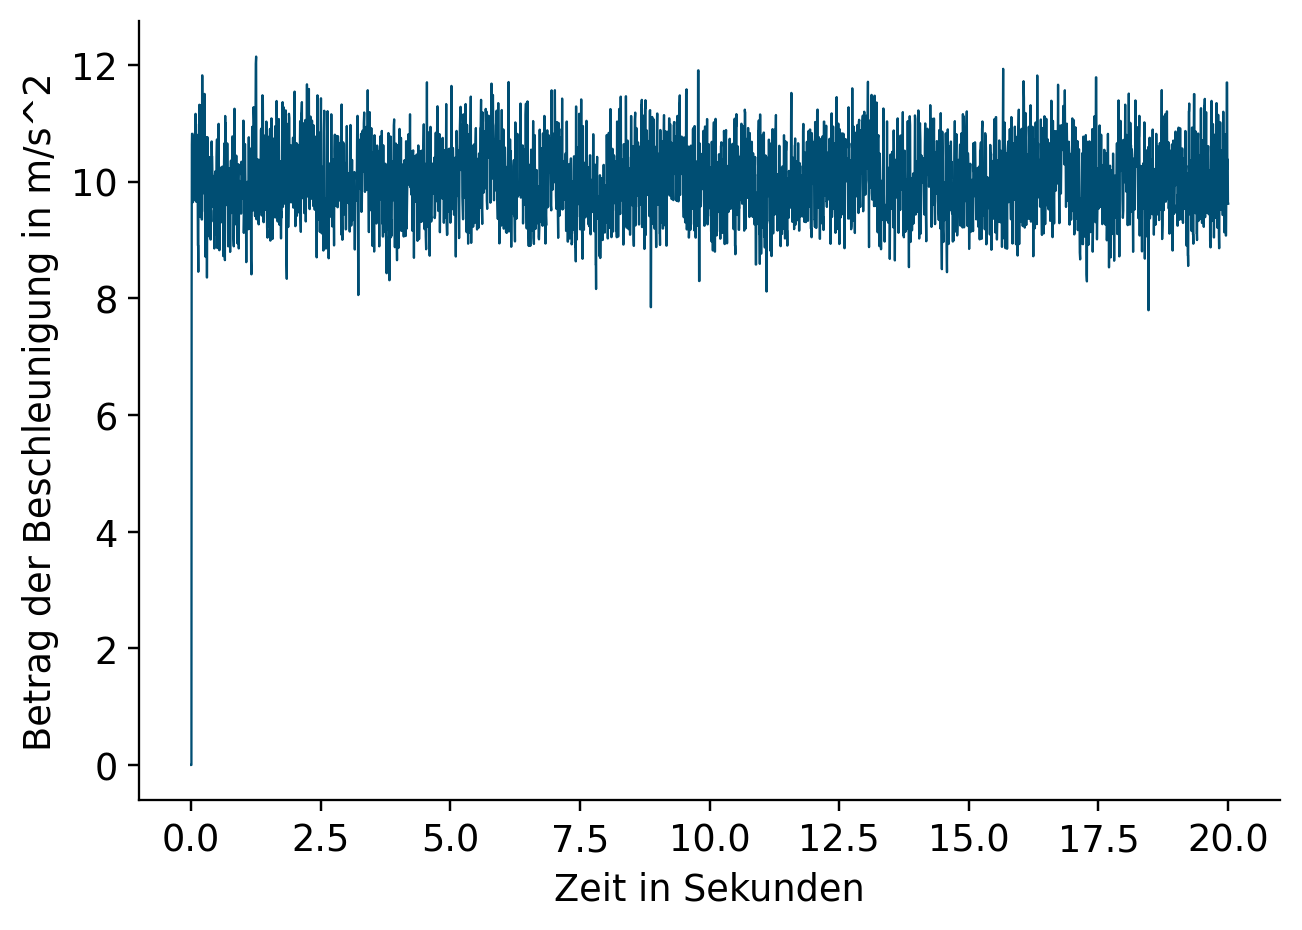

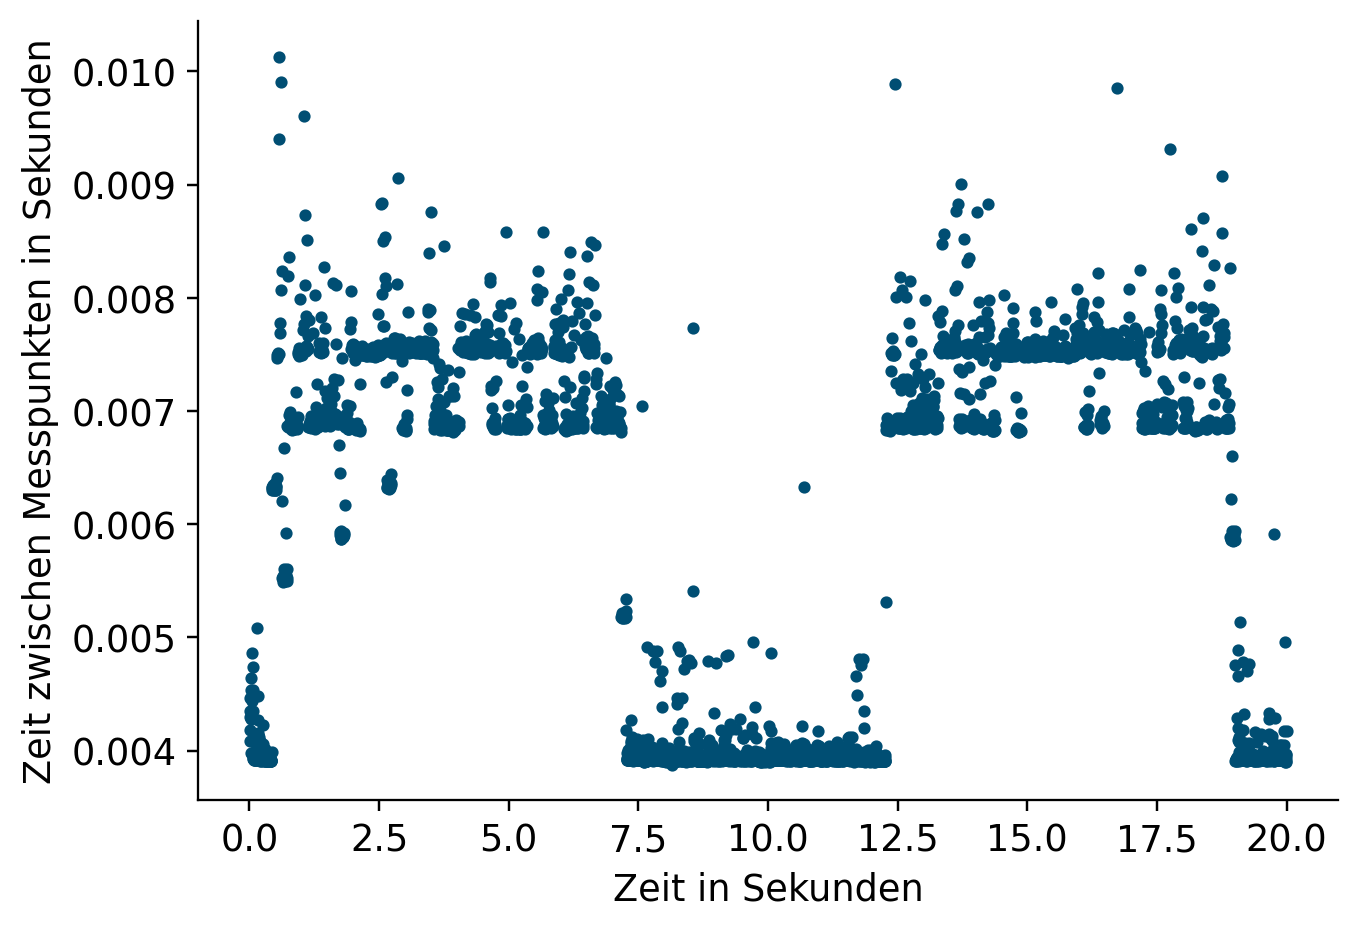

In [40]:
#Erster Plot
fig = plt.figure()
plt.xlabel("Zeit in Sekunden")
plt.ylabel("Betrag der Beschleunigung in m/s^2")
plt.plot(time,betrag_acceleration)

#Zweiter Plot
diff_time = np.diff(time)
fig = plt.figure()
plt.xlabel("Zeit in Sekunden")
plt.ylabel("Zeit zwischen Messpunkten in Sekunden")
plt.plot(np.delete(time,-1),diff_time,".")

#### 4. Interpolation der Messwerte

Da es sich beim Pi nicht um ein Echtzeit-Messsystem handelt, variieren die Zeitabstände zwischen den Messwerten. Da für die FFT äquidistante Messwerte benötigt werden, ist eine Interpolation der Daten erforderlich.

In [41]:
# -------------------------------------------------------------------------------------------#4-start
# TODO: Write the function interpolation() (in m_postprocessing) to linearly interpolate the
# acceleration.
time_int, betrag_acceleration_int = interpolation(time, betrag_acceleration)

#### 5 & 6. FFT durchführen und graphisch darstellen

Transformieren Sie die interpolierten Beträge der Beschleunigung mit der Funktion ```my_fft()``` in den Frequenzraum. Eine Skalierung der Amplitude der FFT ist nicht notwendig.
Stellen Sie die Amplitude des Signals als Funktion der Frequenz graphisch dar.

<StemContainer object of 3 artists>

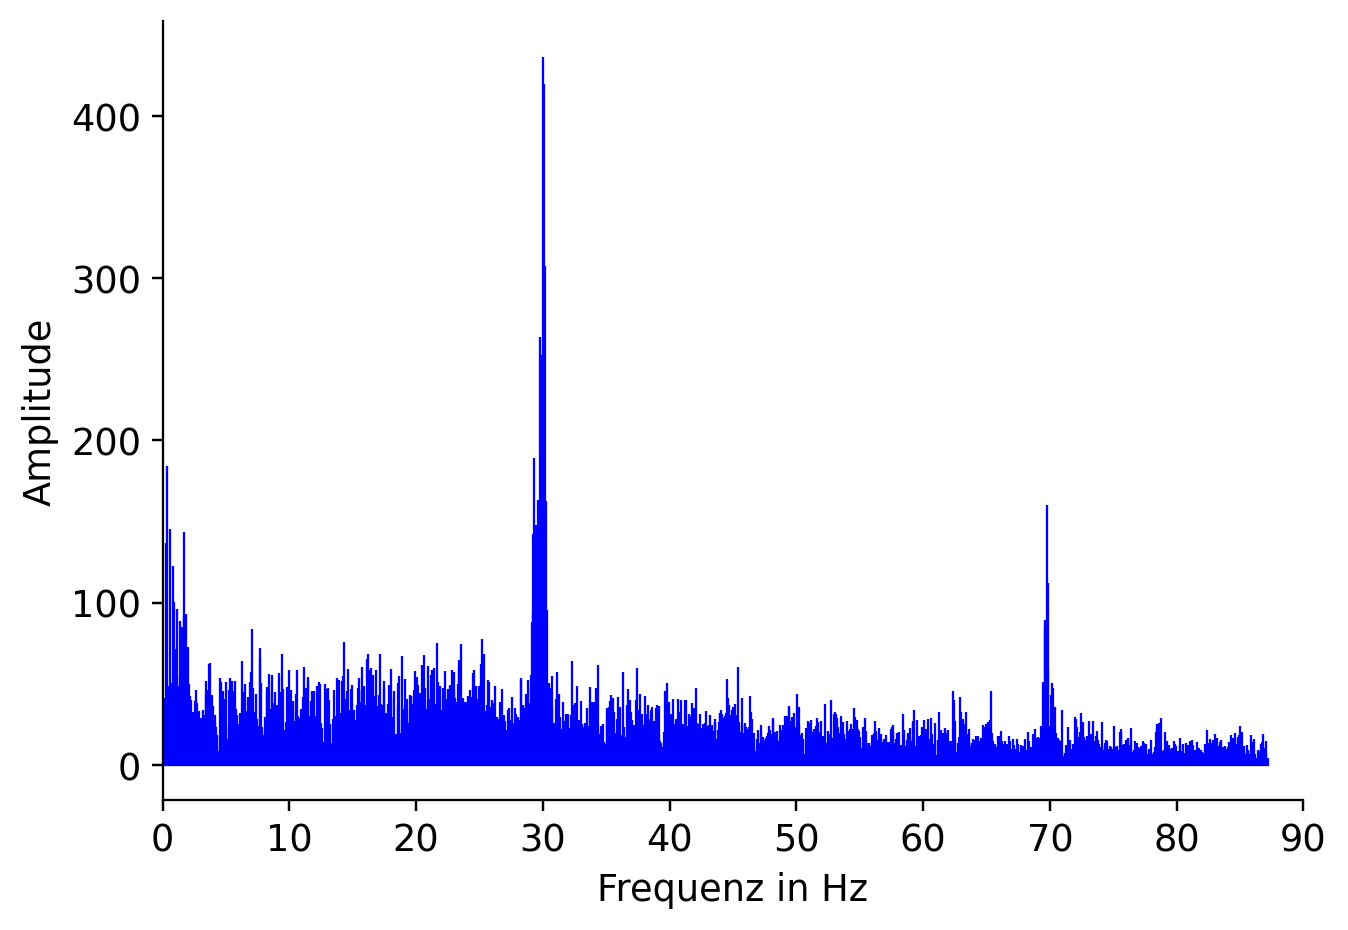

In [42]:
# -------------------------------------------------------------------------------------------#5-start
# TODO: Write my_fft() (in m_postprocessing) and plot results.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
amplitude , frequenz = my_fft(betrag_acceleration_int, time_int)

fig = plt.figure()
plt.xlabel("Frequenz in Hz")
plt.ylabel("Amplitude")
plt.xlim(0, 90)
plt.stem(frequenz,amplitude, 'b', markerfmt=" ", basefmt="-b")

# Zweiter Versuch
Hier werten Sie den zweiten Gegenstand aus.

##  Versuchsaufbau und -durchführung

Beachten Sie, dass Sie den Code zum Auslesen des Beschleunigungssensor ausschließlich mit dem Raspberry Pi ausführen können.

- Bild von Aufbau des Haushaltsgegenstands:

<img src="figures/lautsprecher.jpg" width="500">

- Beschreibung des Aufbaus:

Der Lautsprecher steht auf einem Tisch. An der Oberseite des Lautsprecher ist ein Beschleunigungssensor mit Klebeband befestigt. Der Beschleunigungssensor ist über Jumperkabel mit dem Raspberry Pi verbunden.
- Vorgangsbeschreibung:

Auf dem Lautsprecher wird ein Lied abgespielt. Wenn das Lied läuft wird das Messprogramm gestartet. Nach 20 Sekunden stoppt das Messprogramm selbsständig und die Messdaten werden gespeichert.

## Versuchsauswertung

Führen Sie die obige Auswertung für den zweiten Gegenstand durch. Sie brauchen dafür nichts neu zu implementieren.

#### 1a. Einlesen der Mess- und Metadaten

In [43]:
path_measurement_folder = "measurement_data/data_20240102_193158_NoelSchwibus_lautsprecher" # replace None by the relative path to the first object's folder
h5_file_name = "data_20240102_193158_NoelSchwibus_lautsprecher"

#### 1b. Auslesen der Beschleunigungen und der Zeit in numpy-arrays

In [44]:
file = h5py.File("measurement_data/data_20240102_193158_NoelSchwibus_lautsprecher/data_20240102_193158_NoelSchwibus_lautsprecher.h5","r")

data = file["1ee847be-fddd-6ee4-892a-68c4555b0981"]

acceleration_x = np.array(data['acceleration_x'])
acceleration_y = np.array(data['acceleration_y'])
acceleration_z = np.array(data['acceleration_z'])
time = np.array(data['timestamp'])

#### 2. Betrag der Beschleunigung berechnen


In [45]:
betrag_acceleration = get_vec_accel(acceleration_x, acceleration_y, acceleration_z)

#### 3. Darstellung der Messdaten

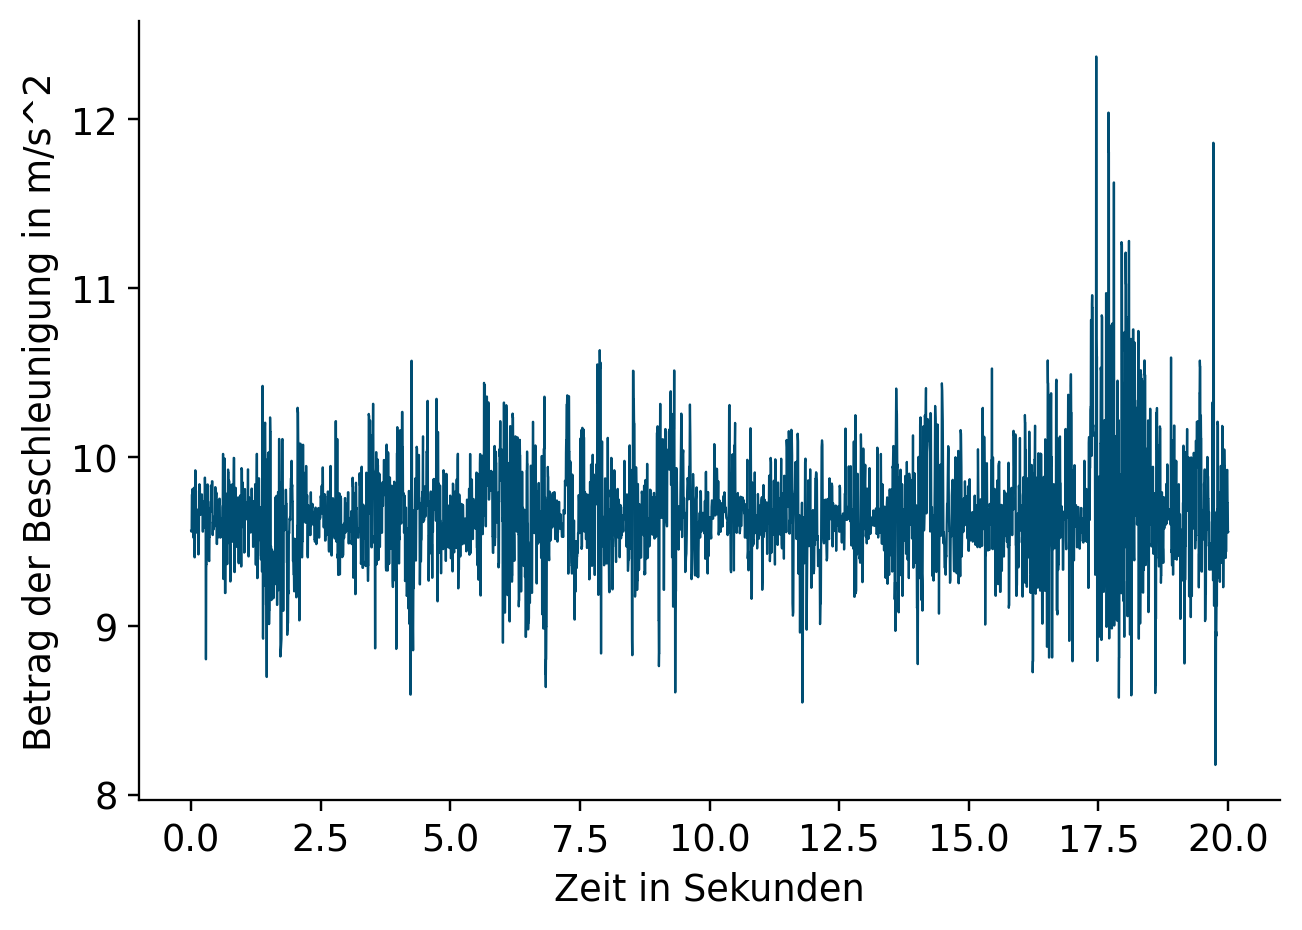

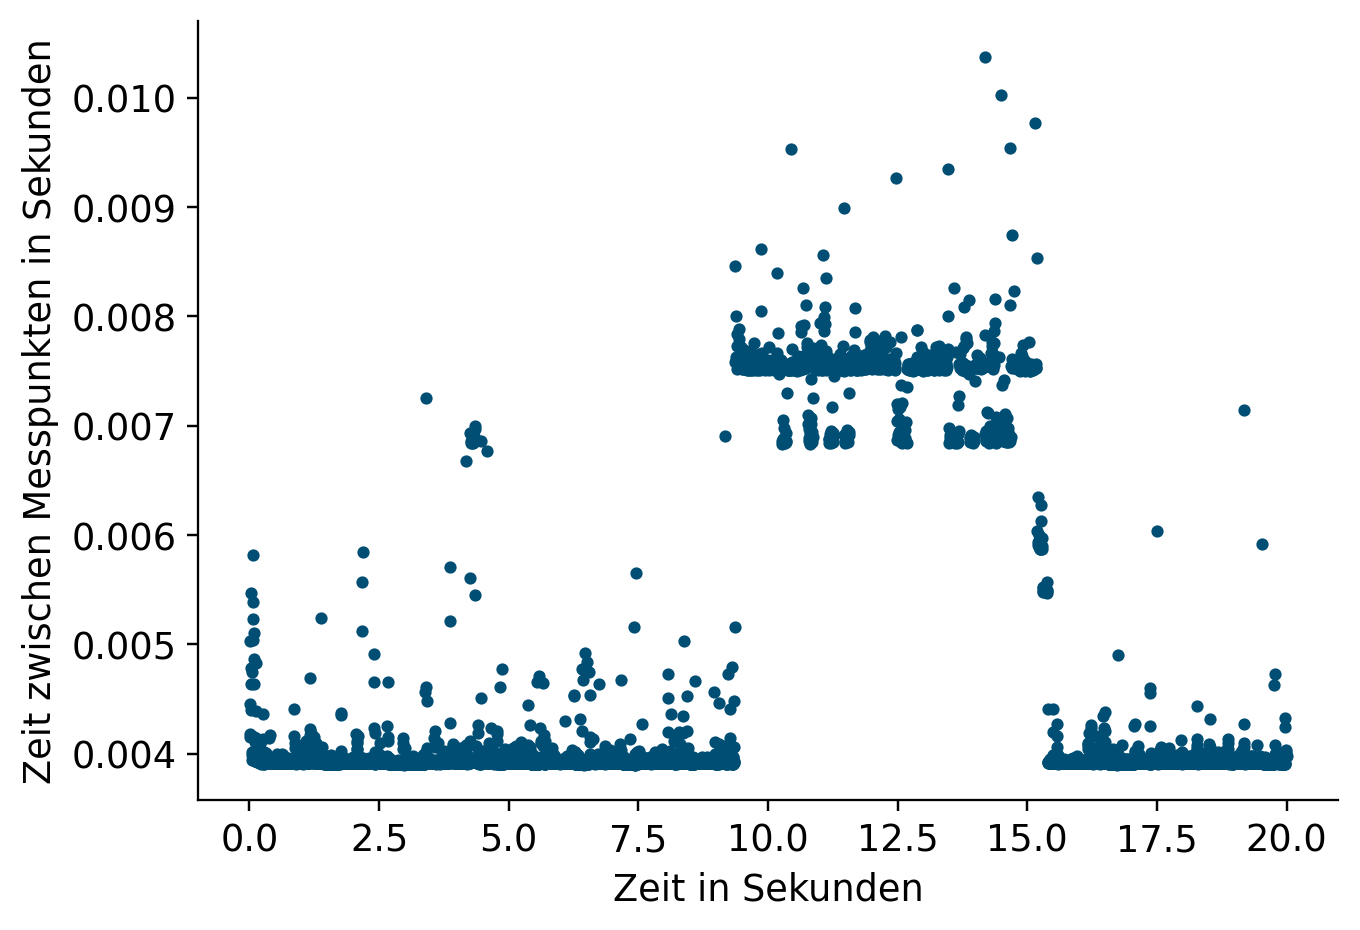

In [46]:
#Erster Plot
fig = plt.figure()
plt.xlabel("Zeit in Sekunden")
plt.ylabel("Betrag der Beschleunigung in m/s^2")
plt.plot(time,betrag_acceleration)

#Zweiter Plot
diff_time = np.diff(time)
fig = plt.figure()
plt.xlabel("Zeit in Sekunden")
plt.ylabel("Zeit zwischen Messpunkten in Sekunden")
plt.plot(np.delete(time,-1),diff_time,".")

#### 4. Interpolation der Messwerte



In [47]:
time_int, betrag_acceleration_int = interpolation(time, betrag_acceleration)

#### 5 & 6. FFT durchführen und graphisch darstellen


<StemContainer object of 3 artists>

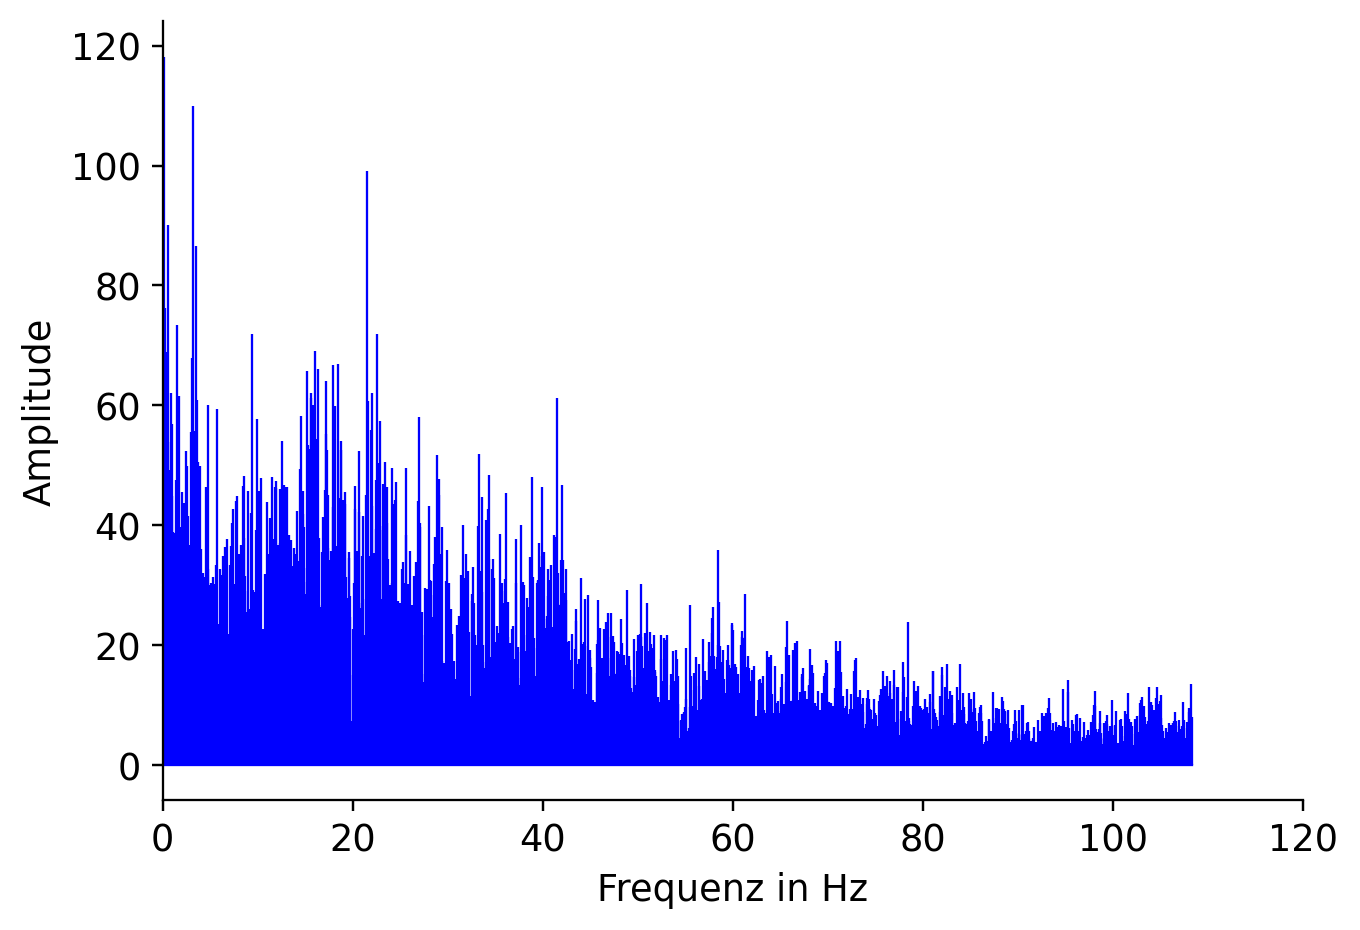

In [48]:
amplitude , frequenz = my_fft(betrag_acceleration_int, time_int)

fig = plt.figure()
plt.xlabel("Frequenz in Hz")
plt.ylabel("Amplitude")
plt.xlim(0, 120)
plt.stem(frequenz,amplitude, 'b', markerfmt=" ", basefmt="-b")

## Diskussion
Diskutieren Sie die Ergebnisse Ihrer Experimente aus wissenschaftlicher Sicht, gehen Sie dabei insbesondere auch auf die zu Beginn aufgestellte Forschungsfrage ein. Beispielsweise können Sie hier auf Einschränkungen der Aussagekraft der Ergebnisse eingehen.

Im ersten Versuch konnten die Vibrationen des Mixers gut erfasst werden. Vor allem können im Frequenzbereich eindeutige Maxima erkannt werden. Diese liegen bei 0, 27 und 71 Hertz. Die Frequenz von 27 Hertz enspricht einer Drehzahl von 1620 rpm. Diese Drehzahl scheint mir realistisch für einem Mixermotor, welcher bei mittlerer Stufe dreht.

Das Frequenzspektrum des Lautsprechers im zweiten Versuch unterscheidet sich deutlich vom ersten Versuch. Es gibt deutlich mehr Maxima, die jedoch nicht so stark herrausstechen. Die starken niedrigen Frequenzen resultieren vermutlich aus dem Bass und Beat des Liedes. Diese sind nämlich sehr regelmäßig, wodurch auch die große Amplitude resultiert. In einem Lied sind jedoch deutlich mehr Frequenzen durch Stimmen und Instrumente als bei einem Mixer. Diese Charakteristiken lassen sich gut erkennen.

## Fazit
Ziehen Sie ein Fazit zum durchgeführten Versuch, gehen Sie dabei gerne auf Ihrer persönliche Meinung oder Ihre Lernziele ein.

Dieser Versuch hat mir bis jetzt am meisten Spaß gemacht. Denn auch die Ergebnisse sind am aussagekräftigsten. Vorallem finde ich es sehr erstaunlich das durch die Messung die Drehzahl des Mixer ermittelt werden kann. Ebenso sind die Charakteristiken der verschiedenen Geräte gut zu erkennen.